# 성능개선 기법 실습


# 모듈 정의


## train.py

-   모델 학습과 검증 함수 정의


In [1]:
import os

os.makedirs("module", exist_ok=True)

In [6]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy


def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)  # 총 데이터개수
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    Args:
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    
    Returns:
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, 
        save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    Args:
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler: Learning Rate Scheduler 객체. default: None, Epoch 단위로 LR 를 변경.
    
    Returns:
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        #########  train
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        
        ############ 1 epoch 학습 종료 -> LR 를 변경 ###########
        if lr_scheduler is not None:
            current_lr = lr_scheduler.get_last_lr()[0]  # log용
            lr_scheduler.step()
            new_lr = lr_scheduler.get_last_lr()[0] # log용
            if current_lr != new_lr: # LR가 변경되었으면
                print(f">>>>>>Learning Rate가 {current_lr}에서 {new_lr}로 변경됨<<<<<<")

        ############# 검증
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py

-   dataset 생성 함수 제공 모듈


In [5]:
%%writefile module/data.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


## utils.py


In [4]:
%%writefile module/utils.py
# 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    """epoch별 학습 결과를 시각화하는 함수
    epoch별 loss와 accuracy를 시각화한다.

    Args:
        train_loss_list (list): Epoch별 train loss
        train_accuracy_list (list): Epoch별 train accuracy
        valid_loss_list (list): Epoch별 validation loss
        valid_accuracy_list (list): Epoch별 validation accuracy
    """
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Writing module/utils.py


## Import

In [1]:
import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result

## 하이퍼파라미터, 변수 정의


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"

epochs = 100
batch_size = 256
lr = 0.001

# Data 준비

## mnist 데이터 로딩


In [4]:
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

## Fashion Mnist
# train_loader = load_fashion_mnist_dataset(root_data_path, batch_size)
# test_loader = load_fashion_mnist_dataset(root_data_path, batch_size, False)

In [6]:
len(train_loader.dataset)

60000

In [7]:
classes = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx

In [9]:
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

# 모델의 크기 변경에 따른 성능변화
## 작은 모델

In [ ]:
class SmallModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(784, 16)
        self.lr2 = nn.Linear(16, 10)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = nn.Flatten()(X) # (N, 1, 28, 28) -> (N, 1*28*28)
        out = self.relu(self.lr1(out))

        
        out = self.lr2(out)
        return out

In [11]:
summary(SmallModel(), (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SmallModel                               [100, 10]                 --
├─Linear: 1-1                            [100, 16]                 12,560
├─ReLU: 1-2                              [100, 16]                 --
├─Linear: 1-3                            [100, 10]                 170
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.27
Input size (MB): 0.31
Forward/backward pass size (MB): 0.02
Params size (MB): 0.05
Estimated Total Size (MB): 0.39

In [12]:
small_model = SmallModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_model.parameters(), lr=lr)

In [13]:

result = fit(train_loader, test_loader, small_model, loss_fn, optimizer, epochs,
             save_best_model=False, device=device, mode="multi")

Epoch[1/100] - Train loss: 0.43185 Train Accucracy: 0.88463 || Validation Loss: 0.41586 Validation Accuracy: 0.89460
Epoch[2/100] - Train loss: 0.31704 Train Accucracy: 0.91078 || Validation Loss: 0.30461 Validation Accuracy: 0.91400
Epoch[3/100] - Train loss: 0.27645 Train Accucracy: 0.92133 || Validation Loss: 0.26858 Validation Accuracy: 0.92360
Epoch[4/100] - Train loss: 0.25356 Train Accucracy: 0.92740 || Validation Loss: 0.24936 Validation Accuracy: 0.92840
Epoch[5/100] - Train loss: 0.23499 Train Accucracy: 0.93245 || Validation Loss: 0.23658 Validation Accuracy: 0.93250
Epoch[6/100] - Train loss: 0.22084 Train Accucracy: 0.93582 || Validation Loss: 0.22163 Validation Accuracy: 0.93570
Epoch[7/100] - Train loss: 0.20908 Train Accucracy: 0.93852 || Validation Loss: 0.21483 Validation Accuracy: 0.93850
Epoch[8/100] - Train loss: 0.20034 Train Accucracy: 0.94072 || Validation Loss: 0.20641 Validation Accuracy: 0.94000
Epoch[9/100] - Train loss: 0.19355 Train Accucracy: 0.94335 || V

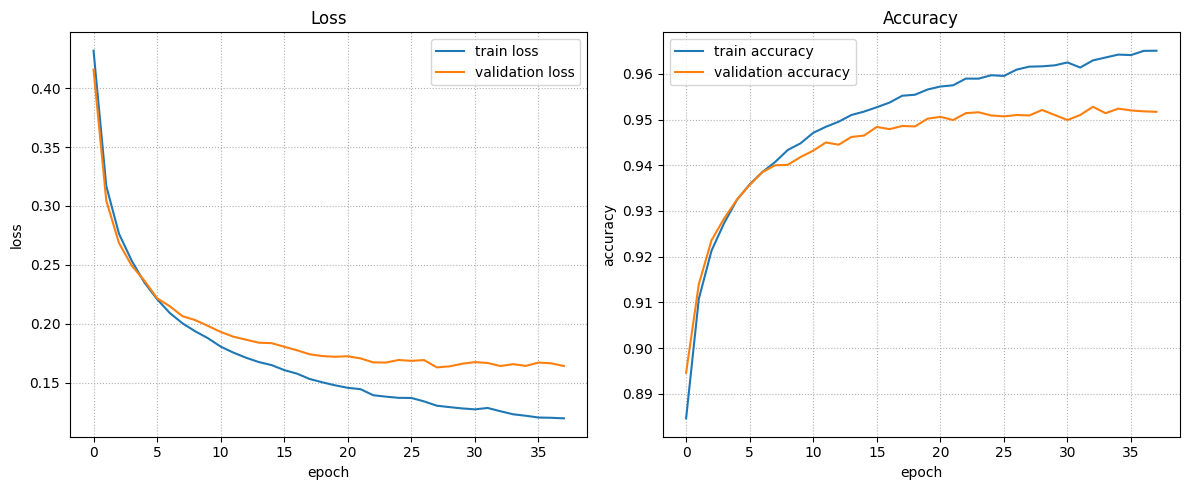

In [14]:
plot_fit_result(result[0], result[1], result[2], result[3])

## 큰모델

In [16]:
class BigModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(784, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_layer = nn.Linear(32, 10)

    def forward(self, X):
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.b7(out)
        out = self.out_layer(out)
        return out

In [18]:
summary(BigModel(), (256, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Flatten: 2-1                      [256, 784]                --
│    └─Linear: 2-2                       [256, 2048]               1,607,680
│    └─ReLU: 2-3                         [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-4                       [256, 1024]               2,098,176
│    └─ReLU: 2-5                         [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-6                       [256, 512]                524,800
│    └─ReLU: 2-7                         [256, 512]                --
├─Sequential: 1-4                        [256, 256]                --
│    └─Linear: 2-8                       [256, 256]               

In [19]:
big_model = BigModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

result = fit(train_loader, test_loader, big_model, loss_fn, optimizer, epochs,
             save_best_model=False, device=device, mode="multi")

Epoch[1/100] - Train loss: 0.17055 Train Accucracy: 0.94882 || Validation Loss: 0.19551 Validation Accuracy: 0.94110
Epoch[2/100] - Train loss: 0.09257 Train Accucracy: 0.97298 || Validation Loss: 0.12182 Validation Accuracy: 0.96530
Epoch[3/100] - Train loss: 0.06087 Train Accucracy: 0.98093 || Validation Loss: 0.09499 Validation Accuracy: 0.97200
Epoch[4/100] - Train loss: 0.03539 Train Accucracy: 0.98870 || Validation Loss: 0.08225 Validation Accuracy: 0.97710
Epoch[5/100] - Train loss: 0.03675 Train Accucracy: 0.98723 || Validation Loss: 0.09246 Validation Accuracy: 0.97500
Epoch[6/100] - Train loss: 0.03019 Train Accucracy: 0.98970 || Validation Loss: 0.09022 Validation Accuracy: 0.97450
Epoch[7/100] - Train loss: 0.02544 Train Accucracy: 0.99088 || Validation Loss: 0.08418 Validation Accuracy: 0.97940
Epoch[8/100] - Train loss: 0.01706 Train Accucracy: 0.99363 || Validation Loss: 0.07555 Validation Accuracy: 0.98090
Epoch[9/100] - Train loss: 0.01660 Train Accucracy: 0.99343 || V

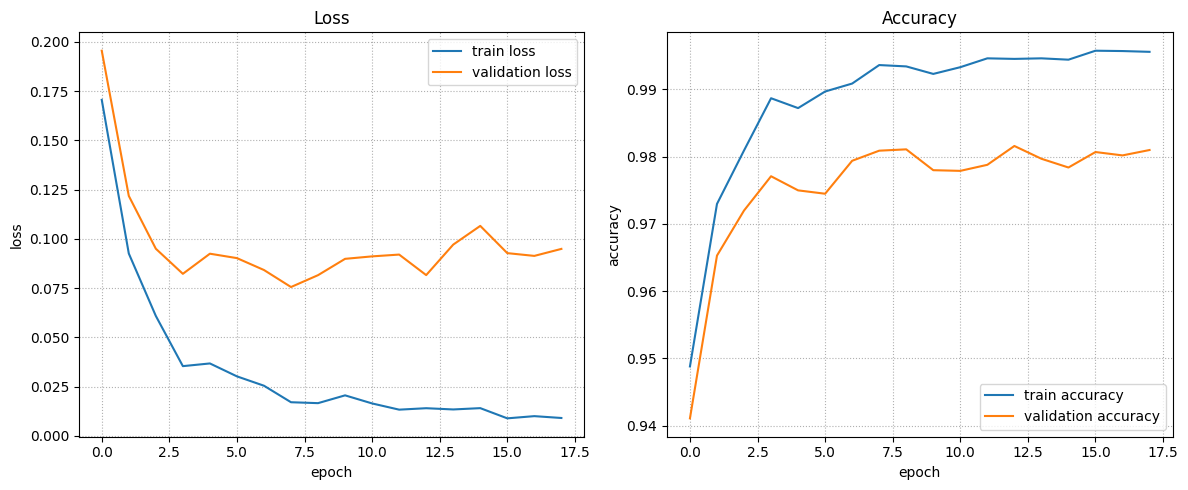

In [20]:
plot_fit_result(result[0], result[1], result[2], result[3])

# Dropout 예제

-   dropout 각 레이어에 적용
    -   dropout은 nn.Dropout 객체를 사용
    -   객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    -   Drop시킬 노드를 가진 Layer 뒤에 추가한다.


In [22]:
# Droput Layer적용:  nn.Linear -> nn.ReLU -> nn.Dropout
class DropOutModel(nn.Module):
    
    def __init__(self, dropout_rate=0.5):

        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(784, 2048), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_layer = nn.Linear(32, 10)

    def forward(self, X):
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.b7(out)
        out = self.out_layer(out)
        return out

In [23]:
summary(DropOutModel(), (256, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropOutModel                             [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Flatten: 2-1                      [256, 784]                --
│    └─Linear: 2-2                       [256, 2048]               1,607,680
│    └─ReLU: 2-3                         [256, 2048]               --
│    └─Dropout: 2-4                      [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-5                       [256, 1024]               2,098,176
│    └─ReLU: 2-6                         [256, 1024]               --
│    └─Dropout: 2-7                      [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-8                       [256, 512]                524,800
│    └─ReLU: 2-9                         [256, 512]               

In [25]:
d_model = DropOutModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(d_model.parameters(), lr=lr)

result = fit(train_loader, test_loader, d_model, loss_fn, optimizer, epochs,
             save_best_model=False, device=device, mode="multi")

KeyboardInterrupt: 

# Batch Normalization

- Dense 와 Activation 사이에 정의한다.


In [10]:
import torch
import torch.nn as nn
from torchinfo import summary

In [11]:
# Droput Layer적용:  nn.Linear -> nn.ReLU -> nn.Dropout
# BatchNorm1d Layer적용:  nn.Linear -> nn.BatchNorm1d -> nn.ReLU -> nn.Dropout
class BatchNormModel(nn.Module):
    
    def __init__(self, dropout_rate=0.5):

        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(784, 2048), nn.BatchNorm1d(2048), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_layer = nn.Linear(32, 10)

    def forward(self, X):
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.b7(out)
        out = self.out_layer(out)
        return out

In [7]:
summary(BatchNormModel(), (256, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BatchNormModel                           [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Flatten: 2-1                      [256, 784]                --
│    └─Linear: 2-2                       [256, 2048]               1,607,680
│    └─BatchNorm1d: 2-3                  [256, 2048]               4,096
│    └─ReLU: 2-4                         [256, 2048]               --
│    └─Dropout: 2-5                      [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-6                       [256, 1024]               2,098,176
│    └─BatchNorm1d: 2-7                  [256, 1024]               2,048
│    └─ReLU: 2-8                         [256, 1024]               --
│    └─Dropout: 2-9                      [256, 1024]               --
├─Sequential: 1-3                        [256, 512]              

# Learning rate decay


### Optimizer와 Learning rate scheduler의 속성, 메소드 확인

-   파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.


In [8]:
import matplotlib.pyplot as plt

def plot_lr(title, lr_list):
    """Learning 스케쥴러(학습도중 LR를 변경시키는 객체.)에 의해 변화되는 Learning Rate값을 시각화.

    Args:
        title (str): title
        lr_list (list): Learning Rate 스케쥴러에 의해 변경된 learning rate값들을 가지는 list
    """
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(lr_list)), lr_list)

    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0] # 눈금을 10 배수 자리에 위치.
    plt.xticks(xticks)
    plt.xlabel("Epoch 수 또는 Step 수")
    plt.ylabel("학습률-LR")
    plt.grid(True, linestyle=":")
    plt.show()

In [12]:
lr = 0.001
model = BatchNormModel()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
# optimizer의 현재 lr 조회
optimizer.param_groups[0]['lr']

0.001

#### StepLR


In [15]:
# 특정 epoch/step 마다 특정 비율로 lr를 변경(보통을 줄여나간다.)
#1. LearningRate Scheduler 객체 생성
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,   #  학습률을 변경할 옵티마이저
    step_size=30,#  몇 epoch/step 당 lr를 변경할지 설정. lr_scheduler.step() - 지정한 횟수(30)만큼 호출하면 변경
    gamma=0.5    # 변경할 비율. 새LR =  현재 lr * gamma
)
step_lr_scheduler.get_last_lr()  # optimizer현재 lr를 조회

[0.001]

In [16]:
# 학습
lr_list = [] # 스케쥴러에게 lr 변경 요청 후 lr를 저장.
epochs = 300
step_size = 20   # for x, y in dataloader: 이 반복횟수 1에폭당 몇번 학습할지.
for epoch in range(epochs):
    # 1 에폭학습
    for step in range(step_size): # for x, y in dataloader:
        # 배치만큼 학습데이터를 가져와서 1 step 학습
        #1. x, y를 device 이동
        #2. model  추론
        #3. loss 계산
        #4. 파라미터들의 gradient 계산
        #5. 파라미터업데이트
        optimizer.step()
        #6. 파라미터의 gradient 초기화
        optimizer.zero_grad()
    # lr 스케쥴러를 이용해서 lr를 변경(스케쥴에 맞춰서 변경)  
    step_lr_scheduler.step()
    lr_list.append(step_lr_scheduler.get_last_lr()[0])


In [21]:
lr_list[-5:]

[1.953125e-06, 1.953125e-06, 1.953125e-06, 1.953125e-06, 9.765625e-07]

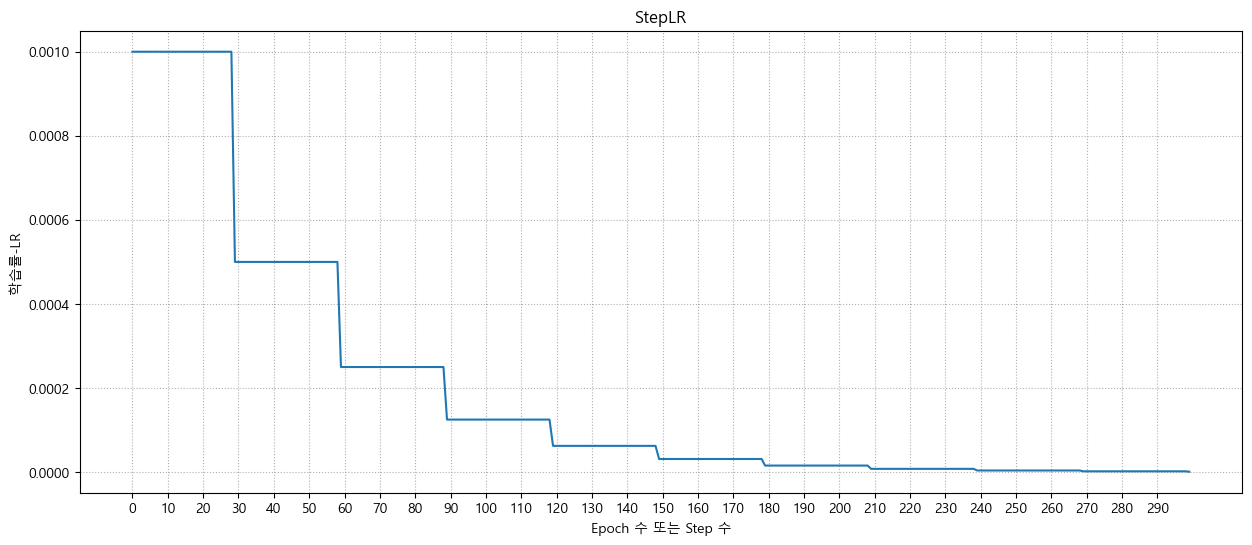

In [20]:
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False
plot_lr("StepLR", lr_list)

#### CosineAnnealingLR

cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.


In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
ca_lr_sch = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=20, # 변화주기 epoch/step(내려가는주기, 올라가는주기)
    eta_min=1e-6, # lr 최소값을 지정. 어디까지 내릴지.
)
# 초기 lr ~ eta_min 사이를 올라갔다 내려갔다 한다.

In [ ]:
lr_list = []
for epoch in range(epochs):
    for step in range(step_size):
        optimizer.step()
        optimizer.zero_grad()

    ca_lr_sch.step()
    lr_list.append(ca_lr_sch.get_last_lr()[0])

In [25]:
lr_list

[7.149673872728684e-06,
 2.5447270110571583e-05,
 5.5442241167912574e-05,
 9.639601130971842e-05,
 0.00014730016279732708,
 0.00020690126647992076,
 0.0002737317453801115,
 0.00034614601130973324,
 0.00042236098471242525,
 0.0005005000000000252,
 0.0005786390152876252,
 0.0006548539886903206,
 0.0007272682546199423,
 0.0007940987335201301,
 0.0008536998372027266,
 0.0009046039886903354,
 0.0009455577588321412,
 0.0009755527298894811,
 0.0009938503261273245,
 0.0010000000000000538,
 0.0009938503261273247,
 0.0009755527298894817,
 0.0009455577588321421,
 0.0009046039886903363,
 0.0008536998372027279,
 0.0007940987335201344,
 0.0007272682546199439,
 0.0006548539886903256,
 0.0005786390152876269,
 0.0005005000000000304,
 0.00042236098471242693,
 0.00034614601130973156,
 0.00027373174538011314,
 0.00020690126647991938,
 0.00014730016279732838,
 9.639601130971947e-05,
 5.5442241167915034e-05,
 2.5447270110572122e-05,
 7.149673872729567e-06,
 1e-06,
 7.149673872728684e-06,
 2.5447270110571526

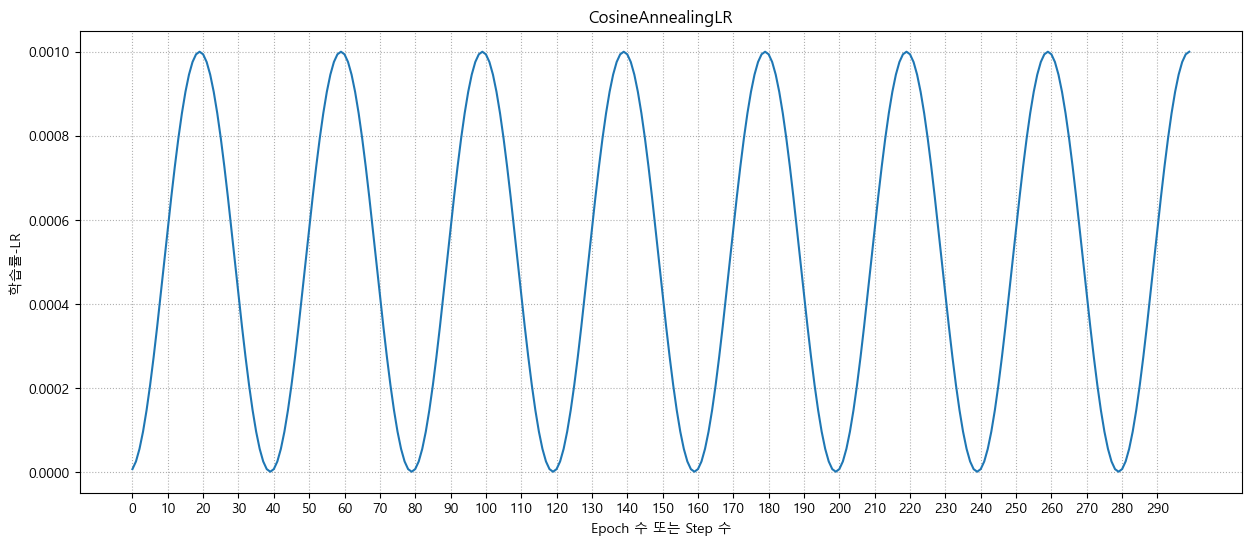

In [26]:
plot_lr("CosineAnnealingLR", lr_list)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
cawr_lr_sche = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,   # 변화주기. (CosineAnnealingLR의 T_max)
    T_mult=2, # 새로운 변화주기 (새 변화주기(T_0) = 현재 변화주기(T_0) * T_mult )
    eta_min=1e-6
)

In [28]:
lr_list = []
for epoch in range(epoch):

    for step in range(step_size):
        optimizer.step()
        optimizer.zero_grad()
    
    cawr_lr_sche.step()
    lr_list.append(cawr_lr_sche.get_last_lr()[0])

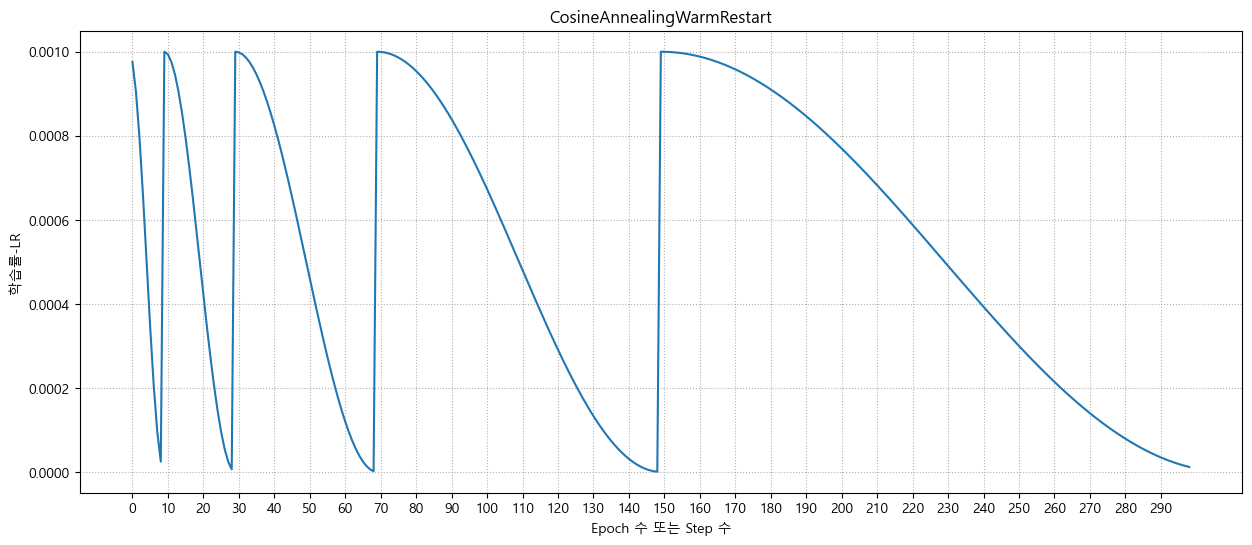

In [29]:
plot_lr("CosineAnnealingWarmRestart", lr_list)